In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
##Grab the adult dataset

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                 'capital_gain', 'capital_loss', 'hours_per_week', 
                 'native_country', 'income']

df = pd.read_csv('adult.data', header=None, names=names, na_values=['?', ' ?'])
#create a binary target
df['income_label'] = (df["income"].apply(lambda x: ">50K" in x)).astype(int)
df.drop('income', axis=1, inplace=True)

target_col = 'income_label'
target = df[target_col].values

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.25,random_state=1)

--2021-11-08 18:04:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.1’

adult.data.1        100%[===================>]   3.79M  4.70MB/s    in 0.8s    

2021-11-08 18:04:59 (4.70 MB/s) - ‘adult.data.1’ saved [3974305/3974305]



In [3]:
##Set binning for features, adding more bins can add more accuracy
binning_process = BinningProcess(list(X_train.columns),max_n_bins=2)

In [4]:
estimator = LogisticRegression(solver="lbfgs", class_weight="balanced",penalty='l2')

scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, 
                      scaling_method="min_max",
                      rounding=True,
                      scaling_method_params={"min": 0, "max": 100},reverse_scorecard=True)
                      
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(max_n_bins=2,
                                         variable_names=['age', 'workclass',
                                                         'fnlwgt', 'education',
                                                         'education_num',
                                                         'marital_status',
                                                         'occupation',
                                                         'relationship', 'race',
                                                         'sex', 'capital_gain',
                                                         'capital_loss',
                                                         'hours_per_week',
                                                         'native_country',
                                                         'income_label']),
          estimator=LogisticRegression(class_weight='balanced'),
          reverse_scorecard=True, rounding=T

In [5]:
scorecard.information(print_level=2)

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                   True   * U
    rounding                            True   * U
    verbose                            False   * d
  End options

  Statistics
    Number of records                  24420
    Number of variables                   15
    Target type                       binary

    Number of numerical                    7
    Number of categorical                  8
    Number of selected                    15

  Timing
    Total time                          0.68 sec
    Binning process                     0.53 sec   ( 79.17%)
    Estimator                           0.06 sec   (  8.39%

In [6]:
results = scorecard.table(style="detailed")
resultssum = scorecard.table(style="summary")
resultssum.to_csv("resultssum.csv")

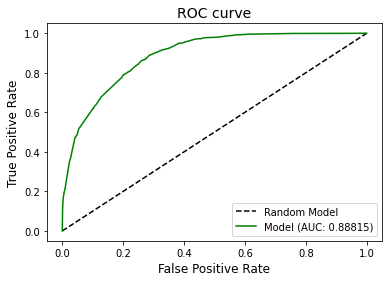

In [7]:
##Get AUC on test
y_pred = scorecard.predict_proba(X_test)[:, 1]
plot_auc_roc(y_test, y_pred)

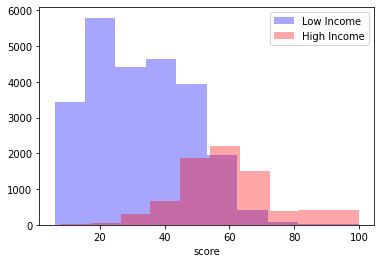

In [10]:
##Print score distribution
score = scorecard.score(df)
mask = target == 0
plt.hist(score[mask], label="Low Income", color="b", alpha=0.35)
plt.hist(score[~mask], label="High Income", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()
